In [1]:
!pip install hypernetx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

# Load the dataset (use ImageFolder or your custom dataset)
dataset = datasets.ImageFolder(root='/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets', transform=transform)

# Split dataset into train and validation sets (70% train, 30% val)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Print dataset sizes to verify
print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")


Training Set Size: 10500
Validation Set Size: 4500


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.utils import from_networkx

# Create hyperedges based on random sampling
import numpy as np

def create_hyperedges(num_images, top_k=5):
    hyperedges = []
    for i in range(num_images):
        # Ensure we do not sample more indices than available
        num_samples = min(num_images - 1, top_k)  # -1 to avoid sampling itself
        similar_indices = np.random.choice(num_images - 1, size=num_samples, replace=False)  # Random sampling
        hyperedge = [i] + similar_indices.tolist()  # Include the current index
        hyperedges.append(hyperedge)
    return hyperedges

# Build a hypergraph from hyperedges
def build_hypergraph(hyperedges):
    H = nx.Graph()
    for edge in hyperedges:
        for i in range(len(edge)):
            for j in range(i + 1, len(edge)):
                H.add_edge(edge[i], edge[j])
    return H

# Convert hypergraph to standard graph
def hypergraph_to_graph(H):
    G = nx.Graph()
    G.add_nodes_from(H.nodes)
    for edge in H.edges:
        G.add_edge(edge[0], edge[1])
    return G

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
from torch_geometric.utils import from_networkx

# Example function to calculate similarity between features and assign weights
def calculate_edge_weights(hyperedges, node_features, similarity_fn=nn.CosineSimilarity(dim=1)):
    edge_weights = []
    for edge in hyperedges:
        edge_weight = 0
        for i in range(len(edge)):
            for j in range(i + 1, len(edge)):
                node_i = torch.tensor(node_features[edge[i]])
                node_j = torch.tensor(node_features[edge[j]])
                # Calculate similarity (e.g., cosine similarity)
                similarity = similarity_fn(node_i.unsqueeze(0), node_j.unsqueeze(0)).item()
                edge_weight += similarity
        edge_weights.append(edge_weight)
    return edge_weights

# Create a weighted hypergraph from hyperedges
def build_weighted_hypergraph(hyperedges, edge_weights):
    H = nx.Graph()
    for edge, weight in zip(hyperedges, edge_weights):
        for i in range(len(edge)):
            for j in range(i + 1, len(edge)):
                H.add_edge(edge[i], edge[j], weight=weight)
    return H

# Example of dynamically updating edge weights during training
def update_edge_weights(hyperedges, node_features, model, optimizer):
    optimizer.zero_grad()
    
    # Calculate new weights based on current node features
    new_weights = calculate_edge_weights(hyperedges, node_features)
    
    # Rebuild hypergraph with new weights
    updated_hypergraph = build_weighted_hypergraph(hyperedges, new_weights)
    
    # Convert to PyTorch Geometric format and use in the model
    graph_data = from_networkx(updated_hypergraph)
    
    # Forward pass through the model
    output = model(graph_data)
    
    # Assume we have a loss to minimize
    loss = some_loss_fn(output, labels)
    loss.backward()
    
    optimizer.step()
    return updated_hypergraph


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualTrackHGNN(nn.Module):
    def __init__(self, cnn_feature_size, hgnn_in_channels, hidden_channels, out_channels, projection_size, hgnn_out_channels):
        super(DualTrackHGNN, self).__init__()

        # CNN Branch
        self.downsampling = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(2),
        )

        # Bottleneck Layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),  
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.LeakyReLU(negative_slope=0.01),
        )

        # Adjust the CNN feature size to match the output after flattening
        self.cnn_fc = nn.Linear(128 * 16 * 16, 128)  # Assuming input size is 256x256 after pooling

        # Upsampling Layer
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )

        # HGNN Branch
        self.hgcn1 = nn.Linear(hgnn_in_channels, out_channels)
        self.hgcn2 = nn.Linear(out_channels, hgnn_out_channels)  # Adjust to provide a correct output size
        self.hgcn_dropout = nn.Dropout(0.5)

        # Projection layers to match sizes before concatenation
        self.feature_projection_cnn = nn.Linear(128, projection_size)  # Adjusting based on CNN output size
        self.feature_projection_hgnn = nn.Linear(hgnn_out_channels, projection_size)  # Using hgnn_out_channels

        # Attention Mechanism
        self.attention_fc = nn.Linear(projection_size * 2, projection_size)

        # Final Fully Connected Layer
        self.fc = nn.Linear(projection_size, 3)

    def forward(self, image: torch.Tensor, graph_features: torch.Tensor, edge_weights: torch.Tensor) -> torch.Tensor:
        # CNN Branch
        x = self.downsampling(image)
        x = self.bottleneck(x)  
        cnn_features = x.view(x.size(0), -1)  # Flatten for fully connected layer
        cnn_features = self.cnn_fc(cnn_features)  # Fully connected layer

        # Upsample
        x = self.upsampling(x)  

        # HGNN Branch
        hgnn_features = F.leaky_relu(self.hgcn1(graph_features), negative_slope=0.01)
        hgnn_features = self.hgcn_dropout(hgnn_features)
        hgnn_features = self.hgcn2(hgnn_features)

        # Ensure feature dimensions match before combining
        cnn_features = self.feature_projection_cnn(cnn_features)  # Project CNN features
        hgnn_features = self.feature_projection_hgnn(hgnn_features)  # Project HGNN features
        
        # Combine CNN and HGNN features with attention
        combined_features = torch.cat([cnn_features, hgnn_features], dim=1)
        attention_weights = torch.sigmoid(self.attention_fc(combined_features))
        combined_features = attention_weights * cnn_features + (1 - attention_weights) * hgnn_features
        
        # Final Output
        output = self.fc(combined_features)
        return output


In [8]:

import torch

# Check if CUDA is available and use it, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the projection size
projection_size = 128  # Adjust based on your architecture

# Model initialization
cnn_feature_size = 256  # Adjust based on your design (not used in the current model)
hgnn_in_channels = 128    # Adjust based on your design
hidden_channels = 128     # Adjust based on your design (not used in the current model)
num_classes = len(dataset.classes)  # Number of output classes

# Initialize the model
model = DualTrackHGNN(
    cnn_feature_size=cnn_feature_size,  # This is not used directly in the model
    hgnn_in_channels=hgnn_in_channels,
    hidden_channels=hidden_channels,  # This is not used directly in the model
    out_channels=num_classes,
    projection_size=projection_size,
    hgnn_out_channels=128  # Adjust based on your design
).to(device)


In [9]:
print(model)

DualTrackHGNN(
  (downsampling): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, 

In [10]:
from tqdm import tqdm  # For progress bars

def train_model_with_dynamic_hypergraph(model, train_loader, val_loader, num_epochs=50, patience=5, hgnn_in_channels=128, top_k=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = np.inf
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop with tqdm progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch_idx, (images, labels) in enumerate(tepoch):
                images, labels = images.to(device), labels.to(device)
                
                # Create hyperedges and calculate edge weights
                hyperedges = create_hyperedges(images.size(0), top_k=top_k)  # Function to create hyperedges
                node_features = torch.rand((images.size(0), hgnn_in_channels)).to(device)  # Random node features
                edge_weights = calculate_edge_weights(hyperedges, node_features)  # Calculate edge weights
                
                optimizer.zero_grad()
                # Forward pass through the model using CNN, hypergraph, and edge weights
                outputs = model(images, node_features, torch.tensor(edge_weights).to(device))
                
                # Compute loss and backpropagate
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Update tqdm with the loss and accuracy
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validation loop
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", unit="batch") as vepoch:
            with torch.no_grad():
                for val_images, val_labels in vepoch:
                    val_images, val_labels = val_images.to(device), val_labels.to(device)
                    val_node_features = torch.rand((val_images.size(0), hgnn_in_channels)).to(device)
                    val_hyperedges = create_hyperedges(val_images.size(0), top_k=top_k)
                    val_edge_weights = calculate_edge_weights(val_hyperedges, val_node_features)

                    val_outputs = model(val_images, val_node_features, torch.tensor(val_edge_weights).to(device))
                    val_loss = criterion(val_outputs, val_labels)

                    val_running_loss += val_loss.item()
                    _, val_predicted = val_outputs.max(1)
                    val_total += val_labels.size(0)
                    val_correct += val_predicted.eq(val_labels).sum().item()

                    # Update tqdm for validation loss and accuracy
                    vepoch.set_postfix(val_loss=val_loss.item(), val_accuracy=100. * val_correct / val_total)

        val_loss = val_running_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Update learning rate
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model)
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [11]:
import matplotlib.pyplot as plt
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot Losses
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

In [12]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_dynamic_hypergraph(
     model,
     train_loader,
     val_loader,
     num_epochs=30,
     patience=5 
)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/30:   0%|          | 0/657 [00:00<?, ?batch/s]/tmp/ipykernel_30/1070048509.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_i = torch.tensor(node_features[edge[i]])
/tmp/ipykernel_30/1070048509.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_j = torch.tensor(node_features[edge[j]])
Epoch 1/30: 100%|██████████| 657/657 [04:02<00:00,  2.70batch/s, accuracy=75, loss=0.136]  


Epoch 1/30, Train Loss: 0.5278, Train Accuracy: 74.95%


Validating Epoch 1/30: 100%|██████████| 282/282 [01:29<00:00,  3.14batch/s, val_accuracy=88.2, val_loss=0.23] 


Validation Loss: 0.3163, Validation Accuracy: 88.22%


Epoch 2/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=87.9, loss=0.0577]


Epoch 2/30, Train Loss: 0.3060, Train Accuracy: 87.93%


Validating Epoch 2/30: 100%|██████████| 282/282 [01:05<00:00,  4.33batch/s, val_accuracy=89.3, val_loss=0.123] 


Validation Loss: 0.2805, Validation Accuracy: 89.29%


Epoch 3/30: 100%|██████████| 657/657 [02:45<00:00,  3.96batch/s, accuracy=89.4, loss=0.222] 


Epoch 3/30, Train Loss: 0.2573, Train Accuracy: 89.42%


Validating Epoch 3/30: 100%|██████████| 282/282 [01:03<00:00,  4.46batch/s, val_accuracy=89.3, val_loss=0.327] 


Validation Loss: 0.2397, Validation Accuracy: 89.29%


Epoch 4/30: 100%|██████████| 657/657 [02:47<00:00,  3.92batch/s, accuracy=91.1, loss=0.0124]


Epoch 4/30, Train Loss: 0.2212, Train Accuracy: 91.12%


Validating Epoch 4/30: 100%|██████████| 282/282 [01:01<00:00,  4.61batch/s, val_accuracy=92.1, val_loss=0.159]  


Validation Loss: 0.1842, Validation Accuracy: 92.07%


Epoch 5/30: 100%|██████████| 657/657 [02:45<00:00,  3.97batch/s, accuracy=92.1, loss=0.0893] 


Epoch 5/30, Train Loss: 0.1987, Train Accuracy: 92.08%


Validating Epoch 5/30: 100%|██████████| 282/282 [01:04<00:00,  4.40batch/s, val_accuracy=91.6, val_loss=0.0585]


Validation Loss: 0.2159, Validation Accuracy: 91.56%


Epoch 6/30: 100%|██████████| 657/657 [02:48<00:00,  3.89batch/s, accuracy=92.7, loss=0.000279]


Epoch 6/30, Train Loss: 0.1796, Train Accuracy: 92.72%


Validating Epoch 6/30: 100%|██████████| 282/282 [01:05<00:00,  4.29batch/s, val_accuracy=94.4, val_loss=0.0579] 


Validation Loss: 0.1606, Validation Accuracy: 94.38%


Epoch 7/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=93.8, loss=0.0155] 


Epoch 7/30, Train Loss: 0.1555, Train Accuracy: 93.78%


Validating Epoch 7/30: 100%|██████████| 282/282 [01:04<00:00,  4.35batch/s, val_accuracy=92.4, val_loss=0.108]  


Validation Loss: 0.1884, Validation Accuracy: 92.38%


Epoch 8/30: 100%|██████████| 657/657 [02:43<00:00,  4.02batch/s, accuracy=93.7, loss=0.0102] 


Epoch 8/30, Train Loss: 0.1559, Train Accuracy: 93.74%


Validating Epoch 8/30: 100%|██████████| 282/282 [01:02<00:00,  4.53batch/s, val_accuracy=94.4, val_loss=0.0334] 


Validation Loss: 0.1620, Validation Accuracy: 94.44%


Epoch 9/30: 100%|██████████| 657/657 [02:47<00:00,  3.93batch/s, accuracy=94.4, loss=0.00714]


Epoch 9/30, Train Loss: 0.1436, Train Accuracy: 94.39%


Validating Epoch 9/30: 100%|██████████| 282/282 [01:01<00:00,  4.56batch/s, val_accuracy=92.8, val_loss=0.0058] 


Validation Loss: 0.2040, Validation Accuracy: 92.80%


Epoch 10/30: 100%|██████████| 657/657 [02:43<00:00,  4.01batch/s, accuracy=94.5, loss=0.019]  


Epoch 10/30, Train Loss: 0.1460, Train Accuracy: 94.46%


Validating Epoch 10/30: 100%|██████████| 282/282 [01:00<00:00,  4.67batch/s, val_accuracy=95.9, val_loss=0.0198] 


Validation Loss: 0.1122, Validation Accuracy: 95.89%


Epoch 11/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=95.4, loss=0.0974] 


Epoch 11/30, Train Loss: 0.1182, Train Accuracy: 95.35%


Validating Epoch 11/30: 100%|██████████| 282/282 [01:05<00:00,  4.33batch/s, val_accuracy=95.9, val_loss=0.0135] 


Validation Loss: 0.1054, Validation Accuracy: 95.91%


Epoch 12/30: 100%|██████████| 657/657 [02:55<00:00,  3.75batch/s, accuracy=95.6, loss=0.0203]  


Epoch 12/30, Train Loss: 0.1143, Train Accuracy: 95.59%


Validating Epoch 12/30: 100%|██████████| 282/282 [01:04<00:00,  4.34batch/s, val_accuracy=95.8, val_loss=0.0145] 


Validation Loss: 0.1028, Validation Accuracy: 95.80%


Epoch 13/30: 100%|██████████| 657/657 [02:58<00:00,  3.69batch/s, accuracy=95.5, loss=0.0255]  


Epoch 13/30, Train Loss: 0.1097, Train Accuracy: 95.48%


Validating Epoch 13/30: 100%|██████████| 282/282 [01:06<00:00,  4.22batch/s, val_accuracy=96.4, val_loss=0.0347] 


Validation Loss: 0.0972, Validation Accuracy: 96.44%


Epoch 14/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=95.4, loss=0.45]    


Epoch 14/30, Train Loss: 0.1231, Train Accuracy: 95.36%


Validating Epoch 14/30: 100%|██████████| 282/282 [01:05<00:00,  4.33batch/s, val_accuracy=94.7, val_loss=0.0257] 


Validation Loss: 0.1363, Validation Accuracy: 94.69%


Epoch 15/30: 100%|██████████| 657/657 [02:50<00:00,  3.85batch/s, accuracy=96.4, loss=0.0367]  


Epoch 15/30, Train Loss: 0.0955, Train Accuracy: 96.41%


Validating Epoch 15/30: 100%|██████████| 282/282 [01:04<00:00,  4.36batch/s, val_accuracy=96, val_loss=0.00959]   


Validation Loss: 0.1095, Validation Accuracy: 96.02%


Epoch 16/30: 100%|██████████| 657/657 [02:54<00:00,  3.76batch/s, accuracy=96.2, loss=0.00122] 


Epoch 16/30, Train Loss: 0.0989, Train Accuracy: 96.24%


Validating Epoch 16/30: 100%|██████████| 282/282 [01:05<00:00,  4.29batch/s, val_accuracy=94.5, val_loss=0.0251] 


Validation Loss: 0.1324, Validation Accuracy: 94.53%


Epoch 17/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=96.1, loss=0.0357]  


Epoch 17/30, Train Loss: 0.1051, Train Accuracy: 96.12%


Validating Epoch 17/30: 100%|██████████| 282/282 [01:04<00:00,  4.37batch/s, val_accuracy=95.8, val_loss=0.0127] 


Validation Loss: 0.1115, Validation Accuracy: 95.78%


Epoch 18/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=97.5, loss=0.0142]  


Epoch 18/30, Train Loss: 0.0718, Train Accuracy: 97.46%


Validating Epoch 18/30: 100%|██████████| 282/282 [01:06<00:00,  4.23batch/s, val_accuracy=97.1, val_loss=0.00662]


Validation Loss: 0.0847, Validation Accuracy: 97.11%


Epoch 19/30: 100%|██████████| 657/657 [02:55<00:00,  3.75batch/s, accuracy=97.8, loss=0.0997]  


Epoch 19/30, Train Loss: 0.0600, Train Accuracy: 97.77%


Validating Epoch 19/30: 100%|██████████| 282/282 [01:05<00:00,  4.31batch/s, val_accuracy=97, val_loss=0.0261]   


Validation Loss: 0.0827, Validation Accuracy: 97.04%


Epoch 20/30: 100%|██████████| 657/657 [02:53<00:00,  3.79batch/s, accuracy=97.8, loss=0.00293] 


Epoch 20/30, Train Loss: 0.0560, Train Accuracy: 97.84%


Validating Epoch 20/30: 100%|██████████| 282/282 [01:04<00:00,  4.35batch/s, val_accuracy=97, val_loss=0.00594]   


Validation Loss: 0.0779, Validation Accuracy: 96.98%


Epoch 21/30: 100%|██████████| 657/657 [02:49<00:00,  3.87batch/s, accuracy=98, loss=0.425]     


Epoch 21/30, Train Loss: 0.0515, Train Accuracy: 98.02%


Validating Epoch 21/30: 100%|██████████| 282/282 [01:10<00:00,  4.01batch/s, val_accuracy=97.4, val_loss=0.00675] 


Validation Loss: 0.0755, Validation Accuracy: 97.42%


Epoch 22/30: 100%|██████████| 657/657 [03:00<00:00,  3.64batch/s, accuracy=98.2, loss=0.00455] 


Epoch 22/30, Train Loss: 0.0469, Train Accuracy: 98.15%


Validating Epoch 22/30: 100%|██████████| 282/282 [01:06<00:00,  4.24batch/s, val_accuracy=96.8, val_loss=0.00503] 


Validation Loss: 0.0929, Validation Accuracy: 96.76%


Epoch 23/30: 100%|██████████| 657/657 [02:57<00:00,  3.71batch/s, accuracy=98.2, loss=7.75e-7] 


Epoch 23/30, Train Loss: 0.0460, Train Accuracy: 98.16%


Validating Epoch 23/30: 100%|██████████| 282/282 [01:19<00:00,  3.56batch/s, val_accuracy=97.6, val_loss=0.00646] 


Validation Loss: 0.0765, Validation Accuracy: 97.60%


Epoch 24/30: 100%|██████████| 657/657 [03:02<00:00,  3.60batch/s, accuracy=98.4, loss=0.00889] 


Epoch 24/30, Train Loss: 0.0422, Train Accuracy: 98.43%


Validating Epoch 24/30: 100%|██████████| 282/282 [01:01<00:00,  4.61batch/s, val_accuracy=97.6, val_loss=0.00547] 


Validation Loss: 0.0745, Validation Accuracy: 97.62%


Epoch 25/30: 100%|██████████| 657/657 [02:42<00:00,  4.04batch/s, accuracy=98.6, loss=0.00109] 


Epoch 25/30, Train Loss: 0.0383, Train Accuracy: 98.55%


Validating Epoch 25/30: 100%|██████████| 282/282 [01:01<00:00,  4.62batch/s, val_accuracy=97.2, val_loss=0.0369]  


Validation Loss: 0.0869, Validation Accuracy: 97.18%


Epoch 26/30: 100%|██████████| 657/657 [02:43<00:00,  4.02batch/s, accuracy=98.6, loss=0.00392] 


Epoch 26/30, Train Loss: 0.0375, Train Accuracy: 98.56%


Validating Epoch 26/30: 100%|██████████| 282/282 [01:01<00:00,  4.60batch/s, val_accuracy=97.7, val_loss=0.00428] 


Validation Loss: 0.0684, Validation Accuracy: 97.67%


Epoch 27/30: 100%|██████████| 657/657 [02:41<00:00,  4.06batch/s, accuracy=98.7, loss=8.18e-5] 


Epoch 27/30, Train Loss: 0.0340, Train Accuracy: 98.73%


Validating Epoch 27/30: 100%|██████████| 282/282 [01:03<00:00,  4.47batch/s, val_accuracy=97.8, val_loss=0.0167]  


Validation Loss: 0.0659, Validation Accuracy: 97.82%


Epoch 28/30: 100%|██████████| 657/657 [02:43<00:00,  4.02batch/s, accuracy=99, loss=0.00773]   


Epoch 28/30, Train Loss: 0.0299, Train Accuracy: 99.02%


Validating Epoch 28/30: 100%|██████████| 282/282 [01:08<00:00,  4.10batch/s, val_accuracy=97.9, val_loss=0.00178] 


Validation Loss: 0.0799, Validation Accuracy: 97.93%


Epoch 29/30: 100%|██████████| 657/657 [02:51<00:00,  3.83batch/s, accuracy=99, loss=2e-6]      


Epoch 29/30, Train Loss: 0.0277, Train Accuracy: 99.03%


Validating Epoch 29/30: 100%|██████████| 282/282 [01:03<00:00,  4.46batch/s, val_accuracy=97.8, val_loss=0.00378] 


Validation Loss: 0.0845, Validation Accuracy: 97.76%


Epoch 30/30: 100%|██████████| 657/657 [02:44<00:00,  4.00batch/s, accuracy=99.1, loss=0.000562]


Epoch 30/30, Train Loss: 0.0272, Train Accuracy: 99.08%


Validating Epoch 30/30: 100%|██████████| 282/282 [01:03<00:00,  4.47batch/s, val_accuracy=97.5, val_loss=0.00148] 

Validation Loss: 0.0762, Validation Accuracy: 97.53%


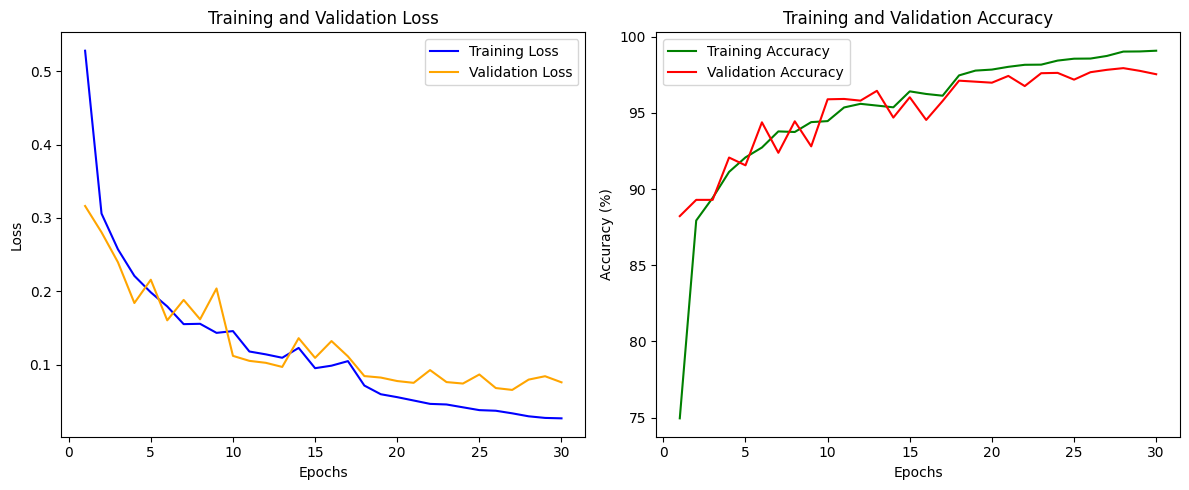

In [13]:
plot_metrics(train_losses,val_losses ,train_accuracies,val_accuracies )
+,m nbvc.